# Imports

In [8]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Sequential
from keras.layers import InputLayer, Conv2D, MaxPool2D, Dense, Flatten, BatchNormalization, Input, Layer, Activation, GlobalAveragePooling2D, LayerNormalization
import matplotlib.pyplot as plt
from PIL import Image

# Prerequisites

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    tf.config.set_visible_devices(gpus[0], 'GPU')

IM_SIZE = 750

# Dataset

In [35]:
dataset_path = dataset_path = r"D:\Education\Code Bases\Python\Metal Analysis\metal_edge_dataset"
dataset = tf.data.Dataset.load(dataset_path)

BATCH_SIZE = 1
dataset = dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

BUFFER_SIZE = 4 # buffer size for shuffling (how many items should be shuffled at once)
dataset = dataset.shuffle(buffer_size=BUFFER_SIZE, reshuffle_each_iteration=False)

In [5]:
'''
    this isn't necessary as dataset size is very low, but we will use it later,
    for now atleast we use the dataset itself for training, no need to split it.
'''

# splits dataset into train, test and validation based on given ratio
def splits(dataset, TRAIN_RATIO, TEST_RATIO, VAL_RATIO):
  DATASET_SIZE = len(dataset)
  train_dataset = dataset.take(int(TRAIN_RATIO * DATASET_SIZE))
  test_dataset = dataset.skip(int(TRAIN_RATIO * DATASET_SIZE)).take(int(TEST_RATIO * DATASET_SIZE))
  val_dataset = dataset.skip(int(TRAIN_RATIO * DATASET_SIZE) + int(TEST_RATIO * DATASET_SIZE))
  return train_dataset, val_dataset, test_dataset

TRAIN_RATIO = 0.8
TEST_RATIO = 0.1
VAL_RATIO = 0.1
train_dataset, val_dataset, test_dataset = splits(dataset, TRAIN_RATIO, TEST_RATIO, VAL_RATIO)

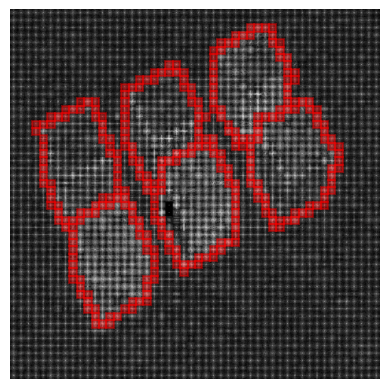

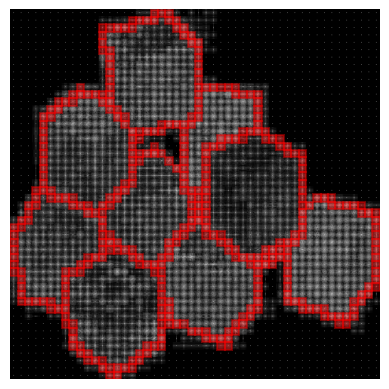

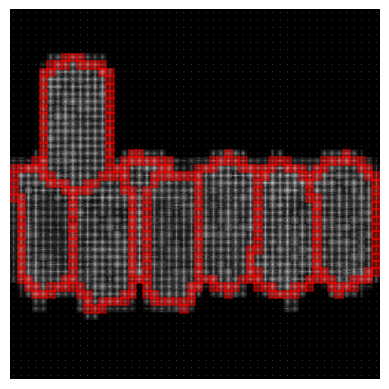

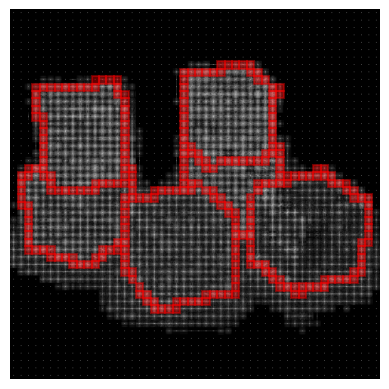

In [45]:
# visualize the images and labels

for image, label in dataset.take(4):
    image = image[0].numpy()
    label = label[0].numpy()

    patch_size = image.shape[0] // label.shape[0]

    fig, ax = plt.subplots()
    ax.imshow(image, vmin=0, vmax=1)

    for i in range(label.shape[0]):
        for j in range(label.shape[1]):
            if label[i, j] == 1:
                x = j * patch_size
                y = i * patch_size
                rect = plt.Rectangle(
                    (x, y), patch_size, patch_size,
                    linewidth=1.5, edgecolor='red', facecolor='red', alpha=0.4
                )
                ax.add_patch(rect)
    ax.axis('off')
    plt.show()

# Model

In [37]:
model = tf.keras.models.Sequential([
    
    InputLayer(input_shape=(750, 750, 3)),

    # first block
    Conv2D(filters=16, kernel_size=15, strides=10, padding='same', activation='relu', kernel_initializer='he_normal'),
    LayerNormalization(),  # Output: (75, 75, 16)

    MaxPool2D(pool_size=(1, 1), padding='same'), 

    # second block
    Conv2D(filters=64, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal'),
    LayerNormalization(),

    # third block
    Conv2D(filters=256, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal'),
    LayerNormalization(),

    # fourth block (thats enough filters)
    Conv2D(filters=512, kernel_size=1, padding='same', activation='relu', kernel_initializer='he_normal'),
    LayerNormalization(),

    # reduce channels to 1
    Conv2D(filters=1, kernel_size=1, padding='same', activation=None, kernel_initializer='he_normal'),

    # resize to final (50x50) (output shape is 1x50x50)
    tf.keras.layers.Resizing(50, 50, interpolation='bilinear'),

    # final sigmoid layer
    Conv2D(filters=1, kernel_size=3, padding='same', activation='sigmoid')
    
])

In [40]:
# regular binary cross entropy didn't work very well, so we use a weighted binary crossentropy
# we punish false negatives more than false positives

def weighted_binary_crossentropy(zero_weight, one_weight):
    
    def loss(y_true, y_pred):
        
        # true labels were initially in integer datatype, so cast to float32 to work with predicted labels
        y_true = tf.cast(y_true, tf.float32)
        bce = tf.keras.backend.binary_crossentropy(y_true, y_pred) # calculate binary cross entropy (for each element)

        '''
            now, we want to assign a weight for each value from binary cross entropy
            here, y_true and y_pred are a 50x50x1 matrix,
            and weight for y_pred[i][j] = weight that should be multiplied with y_pred when y_true is = 1 if y_true[i][j] = 1
            similarly, weight for y_pred[i][j] = weight that should be multiplied with y_pred when y_true is = 0 if y_true[i][j] = 0
            so, the best way to do this is, weights[i][j] = y_true * weight for when y_true is one + (1 - y_true) * weight for when y_true is 0
            since we know y_true[i][j] can either be 0 or 1 only
            if y_true is 1, the second term goes to 0, and if y_true is 0, the first term goes to zero
            so thats how we calculate the weight matrix
        '''
        weights = y_true * one_weight + (1 - y_true) * zero_weight
        return tf.reduce_mean(bce * weights) # now perform element wise multiplication, and return mean of the final matrix
        
    return loss

# we say weight for when y_true = 1 is 10 and zero otherwise
loss_fn = weighted_binary_crossentropy(zero_weight=1.0, one_weight=10.0)

# Training

In [41]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001), loss=loss_fn, metrics=['accuracy'])
history = model.fit(dataset, epochs=200, verbose=1)

Epoch 1/200
4/4 [==============================] - 2s 93ms/step - loss: 2.3222 - accuracy: 0.4447
Epoch 2/200
4/4 [==============================] - 0s 14ms/step - loss: 1.4084 - accuracy: 0.4128
Epoch 3/200
4/4 [==============================] - 0s 15ms/step - loss: 1.2885 - accuracy: 0.4010
Epoch 4/200
4/4 [==============================] - 0s 14ms/step - loss: 1.2326 - accuracy: 0.4118
Epoch 5/200
4/4 [==============================] - 0s 14ms/step - loss: 1.2001 - accuracy: 0.4292
Epoch 6/200
4/4 [==============================] - 0s 15ms/step - loss: 1.1542 - accuracy: 0.4431
Epoch 7/200
4/4 [==============================] - 0s 15ms/step - loss: 1.1301 - accuracy: 0.4526
Epoch 8/200
4/4 [==============================] - 0s 15ms/step - loss: 1.1051 - accuracy: 0.4594
Epoch 9/200
4/4 [==============================] - 0s 14ms/step - loss: 1.0891 - accuracy: 0.4747
Epoch 10/200
4/4 [==============================] - 0s 15ms/step - loss: 1.0706 - accuracy: 0.4889
Epoch 11/200
4/4 [=

In [46]:
# save the model

model.save(r"D:\Education\Code Bases\Python\Metal Analysis\models\MetalEdge.keras")

# Plotting Loss

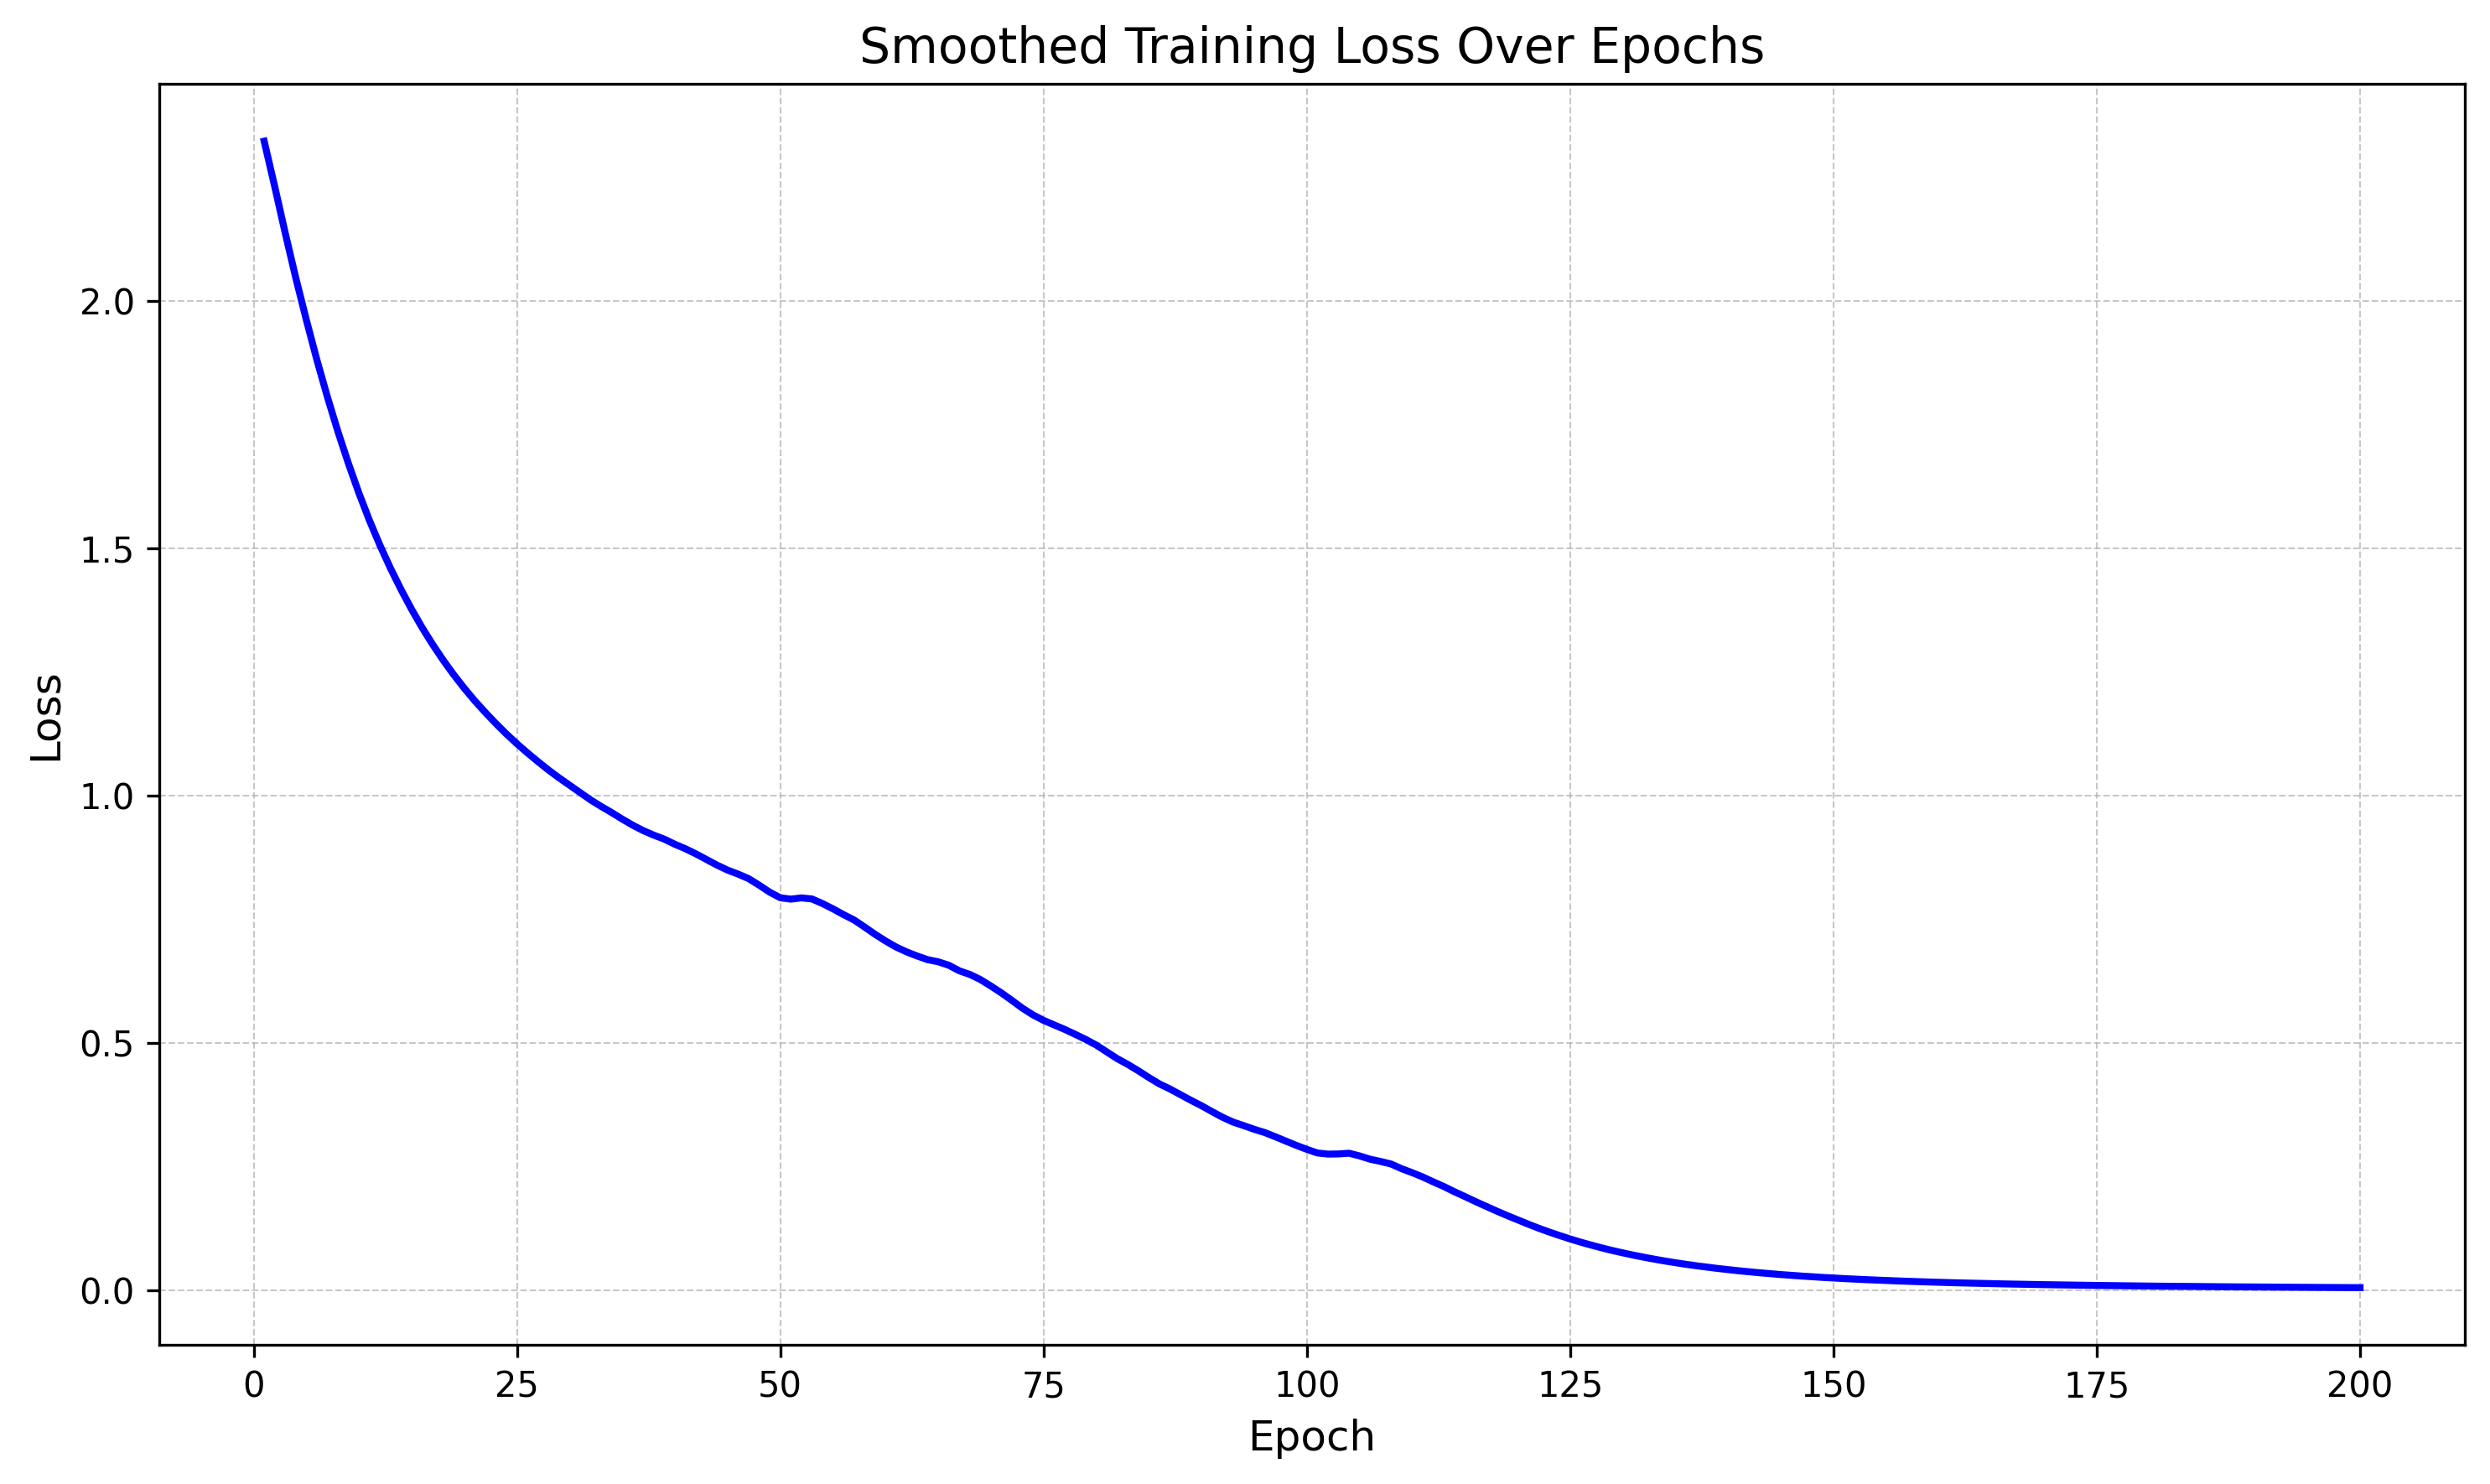

In [42]:
def smooth_curve(points, factor=0.9):
    
    # applies exponential smoothing to a curve
    smoothed = []
    for point in points:
        if smoothed:
            smoothed.append(smoothed[-1] * factor + point * (1 - factor))
        else:
            smoothed.append(point)
    return smoothed

# extract raw loss and val_loss from history
loss = history.history['loss']
val_loss = history.history.get('val_loss', None)

# smooth the losses
smooth_loss = smooth_curve(loss)
smooth_val_loss = smooth_curve(val_loss) if val_loss is not None else None

# plot the smoothed losses
epochs = range(1, len(smooth_loss) + 1)
plt.figure(figsize=(10, 6), dpi=300)  # High-res
plt.plot(epochs, smooth_loss, color='blue', linewidth=2)
plt.plot(epochs, smooth_val_loss, color='red', linewidth=2) if val_loss is not None else None
plt.title(r'Smoothed Training Loss Over Epochs', fontsize=14)
plt.xlabel(r'Epoch', fontsize=12)
plt.ylabel(r'Loss', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.savefig("smoothed_training_loss.png", dpi=300)
plt.show()

# Use the Model

In [9]:
model_path = r"D:\Education\Code Bases\Python\Metal Analysis\models\MetalEdge.keras"
model = tf.keras.models.load_model(model_path)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 250, 250, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 61, 61, 16)        1136      
                                                                 
 flatten (Flatten)           (None, 59536)             0         
                                                                 
 dense (Dense)               (None, 1000)              59537000  
                                                                 
 batch_normalization_2 (Batc  (None, 1000)             4000      
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 100)               100100    
                                                             

In [10]:
# load the model

model_path = r"D:\Education\Code Bases\Python\Metal Analysis\models\MetalEdge.keras"
model = tf.keras.models.load_model(model_path)

1/1 [==============================] - 0s 30ms/step


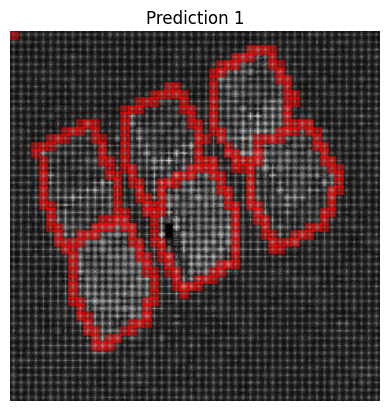

1/1 [==============================] - 0s 37ms/step


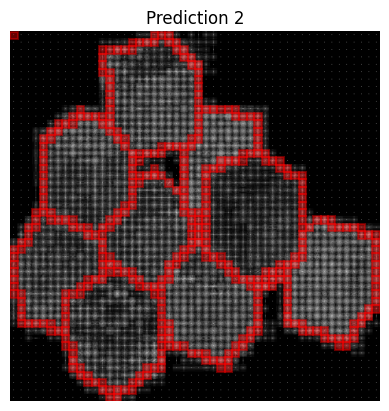

1/1 [==============================] - 0s 32ms/step


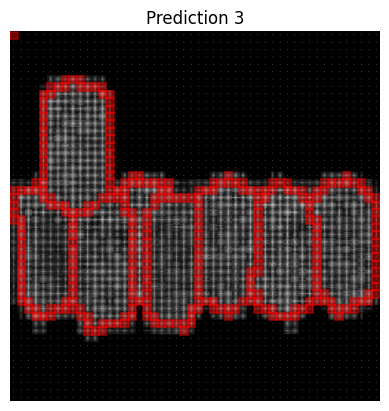

1/1 [==============================] - 0s 27ms/step


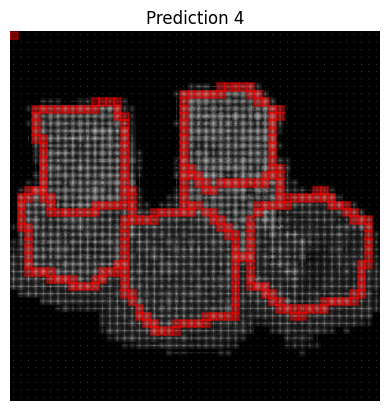

In [52]:
def visualize_predictions(model, dataset, threshold=0.5, max_samples=10):
    
    for idx, (image, label) in enumerate(dataset):
        if max_samples is not None and idx >= max_samples:
            break

        # since the tensorflow model only accpets if the image has a batch dimension,
        # we expand the dimension if no batch dimension is there
        if image.ndim == 3:
            image = tf.expand_dims(image, 0)  # [1, H, W, C]

        # predict
        prediction = model.predict(image)[0]  # Remove batch dim

        # oiginal image
        image_np = image[0].numpy()
        
        patch_size = image_np.shape[0] // prediction.shape[0]

        # visualization
        fig, ax = plt.subplots()
        ax.imshow(image_np, cmap='gray' if image_np.ndim == 2 else None, vmin=0, vmax=1)

        for i in range(prediction.shape[0]):
            for j in range(prediction.shape[1]):
                if prediction[i, j] > threshold:
                    x = j * patch_size
                    y = i * patch_size
                    rect = plt.Rectangle(
                        (x, y), patch_size, patch_size,
                        linewidth=1.5, edgecolor='red', facecolor='red', alpha=0.4
                    )
                    ax.add_patch(rect)

        ax.set_title(f"Prediction {idx + 1}")
        ax.axis('off')
        plt.savefig(f"test_results_{idx + 1}.png")
        plt.show()

visualize_predictions(model, dataset, threshold=0.5, max_samples=10)